# [Titanic Disaster Survival: A Supervised Learning Classification Problem](https://www.kaggle.com/nicapotato/titanic-voting-pipeline-stack-and-guide)
_by Nick Brooks, November 2017_

- [**Github**](https://github.com/nicapotato)
- [**Kaggle**](https://www.kaggle.com/nicapotato/)
- [**Linkedin**](https://www.linkedin.com/in/nickbrooks7)

[Titanic Data Download Link on Kaggle](https://www.kaggle.com/c/titanic/data)

## Methods:
- Machine Learning
- Randomized Tuning
- Ensemble Voting
- Pipelines
- Stacking Models

## Paradigms Discussed:
- Generative and Discriminative Models
- Nonparametric and Parametric Models
- Unsupervised Learning: Dimensionality Reduction
- Regularization

# Table of Content:

**1. Preparation**
    - 1.1 Introduction
    - 1.2 Feature Engineering
    - 1.3 Helper Functions
**2. [Discriminative](#Discriminative) and [Non-Parametric](#Non-Parametric) Models**

    -2.1 Introduction to Confusion Matrix
    -2.2 K-Nearest Neighbors
    -2.3 Stochastic Gradient Descent
  
 **3. [Decision Trees](#Tree)**
   
    -3.1 Introduction to Feature Importance Graphic
    -3.2 Ensemble Methods for Decision Trees
    -3.3 Bootstrap Ensemble
    -3.4 Random Forest
    -3.5 Adaptive Boosting
    -3.6 Gradient Boosting
    -3.7 eXtreme Gradient Boosting

**4. [Parametric Models](#Parametric)**

    -4.1 Logistic Regression
    -4.2 Feedforward Neural Network
    -4.3 Introduction to Support Vector Classifier
    -4.4 Linear Support Vector Classifier
    -4.5 Radial Basis Function
    -4.6 Pipeline and Principal Components Analysis

**5. [Generative Parametric Models](#GPM)**

    -5.1 Gaussian Naive Bayes

**6. [Voting Ensembles](#Vote)**

    -6.1 Stacking
    -6.2 Experimental Accuracy Matrix
    
**7. [Results](#TOR)**

    -7.1 Reflection

# Introduction
<a id="Intro"></a>

**Outsiders introduction to the Titanic Machine Learning Challenge:**
The Titanic Disaster Dataset is based on the sinking of the RMS Titanic on April 14 1912, the largest passenger liner at the time. 1500 out of 2224 of the passengers died in the disaster. The dataset is a collection of the passenger’s name, demographics, cabin class, ticket price, port boarded, and family information. Out of the 2224 passengers onboard, only 1237 are included in the dataset. Out of this 1237, only 891 of the passengers have their fate in the disaster declared. So, whether 418 passengers died or survived is an artificial mystery!

Within Machine learning, Supervised Learning is the process of enabling a computer algorithm to model a set of characteristics to a certain outcome. In the case of this project, the characteristics are the information on each passenger (as stated in the last paragraph), and the outcome is whether the passenger died. It is called *Supervised* because the model learns the relationship by studying characteristic and their outcome of similar events, with the goal of figuring out the outcome of unlabeled event. In this case, the 418 passengers whose outcome is not known. This challenge is the quintessential supervised classification problem, and has served to introduce many to this craft, which has many powerful applications in the real world.


** What I will cover:**
The goal of this notebook is to showcase the wide range of models available through the Sklearn wrapper and how to tune them using randomized search. *Note:* In practice, it is usually better to focus one’s energy on a single high performance model, and thoroughly develop its hyperparameters, and of course ensure quality feature selection and engineering. But that is not the goal of this notebook!

Since such a range of models are explored, I also take the opportunity to explain the axis through which these models differ: **Parametric vs Non-Parametric**, and **Generative vs. Discriminative**

At the end, I also add more flavor to the modeling process by including **Ensemble Voting**, **Pipelining Dimensionality Reduction**, and **Stacking**.

In [1]:
# General Packages
import pandas as pd
import numpy as np
import random as rnd
import os
import re
# import multiprocessing

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')
plt.rcParams['figure.figsize'] = (16, 8)
import scikitplot as skplt

# Supervised Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import feature_selection
import xgboost as xgb
from xgboost.sklearn import XGBClassifier # <3

# Unsupervised Models
from sklearn.decomposition import PCA

# Evalaluation
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Grid
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st

# Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

# Esemble Voting
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score

# Stacking
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from matplotlib.colors import ListedColormap

# Warnings
import warnings
warnings.filterwarnings('ignore')

import time
import datetime
import platform
start = time.time()

In [2]:
print('Version      :', platform.python_version())
print('Compiler     :', platform.python_compiler())
print('Build        :', platform.python_build())

print("\nCurrent date and time using isoformat:")
print(datetime.datetime.now().isoformat())

Version      : 3.5.4
Compiler     : MSC v.1900 64 bit (AMD64)
Build        : ('default', 'Aug 14 2017 13:41:13')

Current date and time using isoformat:
2018-01-23T20:06:40.449835


In [3]:
# Write model submissions?
save = False

# Master Parameters:
n_splits = 5 # Cross Validation Splits
n_iter = 65 # Randomized Search Iterations
scoring = 'accuracy' # Model Selection during Cross-Validation
rstate = 25 # Random State used 
testset_size = 0.30

# Trees Parameters
n_tree_range = st.randint(600, 1200)

# XGboost boosting rounds
num_rounds = 1000

## Loading and Pre-Processing
### Cleaning:
- Category to Numerical representation
- Dealing with Missing Values, and Filling NA


### Feature Engineering:
<a id="FE"></a>
- Extracting Titles from name variable to use as feature
- Rescaling continuous variables

In [4]:
# Load
# train_df = pd.read_csv("../input/train.csv", index_col='PassengerId')
# test_df = pd.read_csv("../input/test.csv", index_col='PassengerId')
train_df = pd.read_csv("Titanic Support/train.csv", index_col='PassengerId')
test_df = pd.read_csv("Titanic Support/test.csv", index_col='PassengerId')

# For Pre-Processing, combine train/test to simultaneously apply transformations
Survived = train_df['Survived'].copy()
train_df = train_df.drop('Survived', axis=1).copy()
df = pd.concat([test_df, train_df])
traindex = train_df.index
testdex = test_df.index
del train_df
del test_df

# New Variables engineering, heavily influenced by:
# Kaggle Source- https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python
# Family Size
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
# Name Length
df['Name_length'] = df['Name'].apply(len)
# Is Alone?
df['IsAlone'] = 0
df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1

# Title: (Source)
# Kaggle Source- https://www.kaggle.com/ash316/eda-to-prediction-dietanic
df['Title']=0
df['Title']=df.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
df['Title'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                    ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

# Age
df.loc[(df.Age.isnull())&(df.Title=='Mr'),'Age']= df.Age[df.Title=="Mr"].mean()
df.loc[(df.Age.isnull())&(df.Title=='Mrs'),'Age']= df.Age[df.Title=="Mrs"].mean()
df.loc[(df.Age.isnull())&(df.Title=='Master'),'Age']= df.Age[df.Title=="Master"].mean()
df.loc[(df.Age.isnull())&(df.Title=='Miss'),'Age']= df.Age[df.Title=="Miss"].mean()
df.loc[(df.Age.isnull())&(df.Title=='Other'),'Age']= df.Age[df.Title=="Other"].mean()
df = df.drop('Name', axis=1)

# Fill NA
# Categoricals Variable
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode().iloc[0])

# Continuous Variable
df['Fare'] = df['Fare'].fillna(df['Fare'].mean())

## Assign Binary to Sex str
df['Sex'] = df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
# Title
df['Title'] = df['Title'].map( {'Mr': 0, 'Mrs': 1, 'Miss': 2, 'Master':3, 'Other':4} )#.astype(int)
df['Title'] = df['Title'].fillna(df['Title'].mode().iloc[0])
df['Title'] = df['Title'].astype(int)

# Embarked
df['Embarked'] = df['Embarked'].map( {'Q': 0, 'S': 1, 'C': 2} ).astype(int)

# Get Rid of Ticket and Cabin Variable
df= df.drop(['Ticket', 'Cabin'], axis=1)

In [5]:
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,Name_length,IsAlone,Title
PassengerId,,,,,,,,,,,
892,3,0,34.5,0,0,7.8292,0,1,16,1,0
893,3,1,47.0,1,0,7.0000,1,2,32,0,1
894,2,0,62.0,0,0,9.6875,0,1,25,1,0
895,3,0,27.0,0,0,8.6625,1,1,16,1,0
896,3,1,22.0,1,1,12.2875,1,3,44,0,1


### Visualization
Before Applying dummy variables, I take the opportunity to look at distributions and correlations.

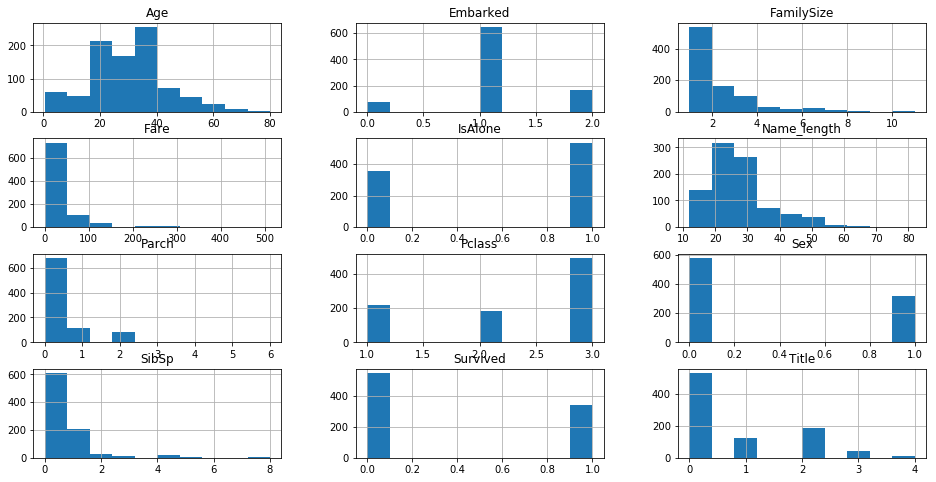

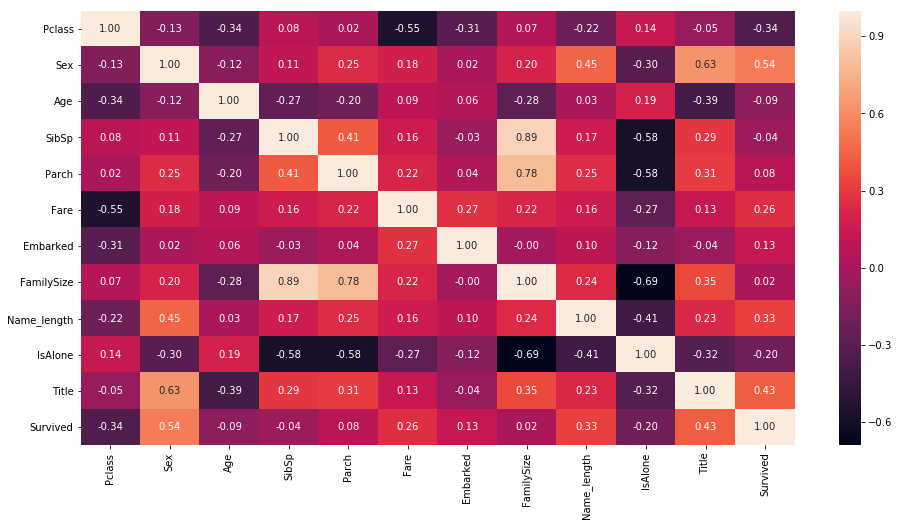

In [6]:
# Histogram
pd.concat([df.loc[traindex, :], Survived], axis=1).hist()
plt.show()

In [ ]:
# Correlation Plot
sns.heatmap(pd.concat([df.loc[traindex, :], Survived], axis=1).corr(), annot=True, fmt=".2f")

In [7]:
# Scaling between -1 and 1. Good practice for continuous variables.
from sklearn import preprocessing
for col in ['Fare','Age','Name_length']:
    transf = df[col].reshape(-1,1)
    scaler = preprocessing.StandardScaler().fit(transf)
    df[col] = scaler.transform(transf)

# Finish Pre-Processing
# Dummmy Variables (One Hot Encoding)
#df = pd.get_dummies(df, columns=['Embarked','Title','Parch','SibSp','Pclass'], )

# Now that pre-processing is complete, split data into train/test again.
train_df = df.loc[traindex, :]
train_df['Survived'] = Survived
test_df = df.loc[testdex, :]

# Dead Weight
del df

## Take Your Position!
Declaring dependent and independent variables as well as helper functions that record the mean cross-validation average of model accuracy, and its standard deviation to understand the volatility of the models.

Also includes remnants of my previous "write submission" system for those interested.

In [8]:
# Depedent and Indepedent Variables
X = train_df.drop(["Survived"] , axis=1)
y = train_df["Survived"]
print("X, Y, Test Shape:",X.shape, y.shape, test_df.shape) # Data Dimensions

# Storage for Model and Results
results = pd.DataFrame(columns=['Model','Para','Test_Score','CV Mean','CV STDEV'])
ensemble_models= {}

X, Y, Test Shape: (891, 11) (891,) (418, 11)


## Imbalanced Dependent Variable
This signifies that there is an unequal occurrence of the dependent variable "Survived". This could potentially lead to a flawed model. I deal with this by stratifying the train/test groups, leading to equal representation of classes. Additional methods to handle imbalanced datasets include data augmentation and re-sampling methods.

In [9]:
print("Depedent Variable Distribution")
print(y.value_counts(normalize=True)*100)
print("0 = Died", "\n1 = Survived")

Depedent Variable Distribution
0    61.616162
1    38.383838
Name: Survived, dtype: float64
0 = Died 
1 = Survived


# Understanding Feature Importance
- Dimensionality Reduction with [Principal Component Analysis](https://machinelearningmastery.com/feature-selection-machine-learning-python/)
- Statistically Selecting Best Features with [SelectKBest](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)

### Dimensionality Reduction: Principal Components

In [10]:
print("Feature Count (With One Hot Encoding):", X.shape[1])

Feature Count (With One Hot Encoding): 11


In [11]:
levels = [2,4,6,8,10,12]
for x in levels:
    pca = PCA(n_components=x)
    fit = pca.fit(train_df)

    print(("{} Components \nExplained Variance: {}\n").format(x, fit.explained_variance_ratio_))
    #print(fit.components_)

2 Components 
Explained Variance: [ 0.45118983  0.15874474]

4 Components 
Explained Variance: [ 0.45118983  0.15874474  0.12176714  0.08256849]

6 Components 
Explained Variance: [ 0.45118983  0.15874474  0.12176714  0.08256849  0.05365997  0.04790129]

8 Components 
Explained Variance: [ 0.45118983  0.15874474  0.12176714  0.08256849  0.05365997  0.04790129
  0.02951155  0.02154033]

10 Components 
Explained Variance: [ 0.45118983  0.15874474  0.12176714  0.08256849  0.05365997  0.04790129
  0.02951155  0.02154033  0.01540524  0.00968405]

12 Components 
Explained Variance: [  4.51189827e-01   1.58744743e-01   1.21767143e-01   8.25684936e-02
   5.36599696e-02   4.79012925e-02   2.95115511e-02   2.15403319e-02
   1.54052385e-02   9.68405467e-03   8.02735490e-03   6.14062698e-33]



In [12]:
"""
# Reduce Dimensionality
pca = PCA(n_components=5)
fit = pca.fit(X)

sns.heatmap(pd.concat([pd.DataFrame(fit.transform(X)), Survived],
                      axis=1).corr(), annot=True, fmt=".2f")
# Apply Reduction
X = pd.DataFrame(fit.transform(X))
test_df = pd.DataFrame(fit.transform(test_df))

No longer applied to dataset since performance did not get substancially improved.
Better just use method at an individual basis, through the pipeline method.
"""

'\n# Reduce Dimensionality\npca = PCA(n_components=5)\nfit = pca.fit(X)\n\nsns.heatmap(pd.concat([pd.DataFrame(fit.transform(X)), Survived],\n                      axis=1).corr(), annot=True, fmt=".2f")\n# Apply Reduction\nX = pd.DataFrame(fit.transform(X))\ntest_df = pd.DataFrame(fit.transform(test_df))\n\nNo longer applied to dataset since performance did not get substancially improved.\nBetter just use method at an individual basis, through the pipeline method.\n'

## Train/Test Split
Declaring dependent and independent variables, as well as preparing the training data into its train-validation-test sets for proper modelling. My validation step is executed during the model fitting process.

Note: Determining model quality through cross-validation is not correct if hyper-parameter tuning is applied, since this leads to a (hyper-parameter) overfitted evaluation of the model. Use an additional untouched test set.

Stratified cross validation splits are used. Number of splits is declared at the start of notebook.

In [13]:
# Stratified Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testset_size, stratify=y,random_state=rstate)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# Stratified Cross-Validation
cv = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=rstate)

## Helper Functions
<a id="HF"></a>

In [1]:
# Compute, Print, and Save Model Evaluation
def save(model, modelname):
    """
    This funciton saves the cross-validation and held-out (Test Set) accuracy scores aswell as their standard deviations
    to the "results" dataframe, then it executes the model prediction on the submission set.
    Finally, it also outputs a confusion matrix of the test set.
    
    Function Arguments:
    model = The Sklearn Randomized/Grid SearchCV model.
    modelname = String of the model name for saving purposes.
    """
    global results
    # Once best model is found, establish more evaluation metrics.
    model.best_estimator_.fit(X_train, y_train)
    
    # submission = model.predict(test_df)
    # df = pd.DataFrame({'PassengerId':test_df.index,'Survived':submission})
    # path = ...
    # df.to_csv((os.path.join(path,("submissions/{}.csv".format(modelname)))),header=True,index=False)
    
    scores = cross_val_score(model.best_estimator_, X_train, y_train, cv=5,
                             scoring=scoring, verbose =0)
    CV_scores = scores.mean()
    STDev = scores.std()
    Test_scores = model.score(X_test, y_test)

    # CV and Save scores
    results = results.append({'Model': modelname,'Para': model.best_params_,'Test_Score': Test_scores,
                             'CV Mean':CV_scores, 'CV STDEV': STDev}, ignore_index=True)
    ensemble_models[modelname] = model.best_estimator_
    
    # Print Evaluation
    print("\nEvaluation Method: {}".format(scoring))
    print("Optimal Model Parameters: {}".format(grid.best_params_))
    print("Train CV Accuracy: %0.2f (+/- %0.2f) [%s]" % (CV_scores, STDev, modelname))
    print('Test_Score:', Test_scores)
        
    # Scikit Confusion Matrix
    model.best_estimator_.fit(X_train, y_train)
    pred = model.predict(X_test)
    skplt.metrics.plot_confusion_matrix(y_test, pred, title="{} Confusion Matrix".format(modelname),
                normalize=True,figsize=(6,6),text_fontsize='large')
    plt.show()
    # Colors https://matplotlib.org/examples/color/colormaps_reference.html

def norm_save(model,score, modelname):
    global results
    model.fit(X, y)
    submission = model.predict(test_df)
    df = pd.DataFrame({'PassengerId':test_df.index, 
                           'Survived':submission})
    
    CV_Score = score.mean()
    Test_scores = model.score(X_test, y_test)
    STDev = score.std()
    
    # CV and Save Scores
    Test_Score = model.score(X_test, y_test)
    results = results.append({'Model': modelname,'Para': model,'Test_Score': Test_scores,
                             'CV Mean': CV_Score, 'CV STDEV': STDev}, ignore_index=True)
    ensemble_models[modelname] = model
    
    print("\nEvaluation Method: {}".format(scoring))
    print("Train CV Accuracy: %0.2f (+/- %0.2f) [%s]" % (CV_Score, STDev, modelname))  
    print('Test_Score:', Test_scores)
        
    #Scikit Confusion Matrix
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    skplt.metrics.plot_confusion_matrix(y_test, pred, title="{} Confusion Matrix".format(modelname),
                normalize=True,figsize=(6,6),text_fontsize='large')
    plt.show()
    
# ROC Curve Plot
# http://scikit-plot.readthedocs.io/en/stable/metrics.html
def eval_plot(model):
    skplt.metrics.plot_roc_curve(y_test, model.predict_proba(X_test))
    plt.show()

# Non-Parametric
<a id="Non-Parametric"></a>
Counterpart to Parametric models, Parametric models does not make any assumptions about the data generating process’ distribution. For example, in statistical test, Non-Parametric models utilize rank and medians, instead of the mean and variance! On the other hand, they function in a infinite space of parameters, making their name counter-intuitive, but also highlighting their practical approach to representation; enabling them to increase their flexibility indefinitely.

# Discriminative Models
<a id="Discriminative"></a>
Discriminative models do not attempt to quantify how the data generating process operates, instead, its goal is to slice and dice the data to classify the dependent variable, effectively solving the problem by modeling p(y|x). 

## K-Nearest Neighbors
<a id="KNN"></a>
The simplest of all machine learning models, a nonparametric method that works well on short and narrow datasets, but seriously struggles in the high dimensional space. It works by using the *K* nearest point to the predicted point then votes on its class (or continuous number when in the regression context). Note: Since this is a instance based learning algorithm, its function is applied locally, and the computation is deferred until the prediction stage. Furthermore, since the data serves as the “map” for new values, the model size may be clunkier than its counterparts. 

Fitting 5 folds for each of 65 candidates, totalling 325 fits

Evaluation Method: accuracy
Optimal Model Parameters: {'n_neighbors': 20, 'weights': 'distance'}
Train CV Accuracy: 0.80 (+/- 0.03) [KNN]
Test_Score: 0.791044776119


[Parallel(n_jobs=1)]: Done 325 out of 325 | elapsed:    2.4s finished


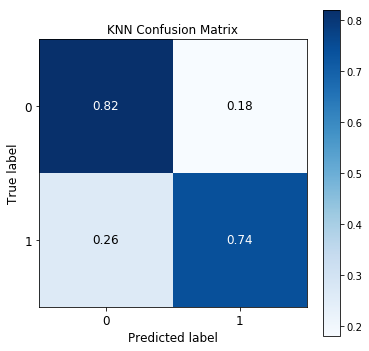

In [15]:
# Hyper parameters. Since RandomizedSearchCV is used, I use an uniform random interger range for the function to choose from.
param_grid ={'n_neighbors': st.randint(1,40),
             # Increasing this value reduces bias, and increases variance. Don't Overfit!
            'weights':['uniform','distance']
            }
# Hyper-Parameter Tuning with Cross-Validation
grid = RandomizedSearchCV(KNeighborsClassifier(),
                    param_grid, # Hyper Parameters
                    cv=cv, # Cross-Validation splits. Stratified.
                    scoring=scoring, # Best-Validation selection metric.
                    verbose=1, # Quality of Life. Frequency of model updates
                    n_iter=n_iter, # Number of hyperparameter combinations tried.
                    random_state=rstate) # Reproducibility 

# Execute Tuning on entire dataset
grid.fit(X_train, y_train)
save(grid, "KNN")

## Introduction to Confusion Matrix
<a id="Conf"></a>

This graphic illustrates the nature of the model mistakes by showing the proportion of false negatives to true negatives, and false positives to true positives. Method is also applicable to results with more than just a binary class.

False Negative: When the model labels a positive observation as negative. For example, when the doctor thinks a pregnant women is not pregnant.
False Positive: When a negative observation is predicted to be positive. When a healthy man is (falsely) told he has cancer.

For the type of sensitive problem described in my examples, model builders may emphasize the minimization of one form of error over the other. We may be more willing to tell healthy person they falsely have cancer, than tell a dying person they have nothing to worry about, and miss the opportunity to receive treatment. 


### Stochastic Gradient Descent
<a id="SGD"></a>

ERROR 404. Adding.. Beep Bop

In [16]:
SGDClassifier().get_params().keys()

dict_keys(['alpha', 'learning_rate', 'eta0', 'penalty', 'l1_ratio', 'shuffle', 'power_t', 'warm_start', 'n_jobs', 'class_weight', 'tol', 'loss', 'average', 'max_iter', 'epsilon', 'n_iter', 'fit_intercept', 'random_state', 'verbose'])

Fitting 5 folds for each of 5 candidates, totalling 25 fits

Evaluation Method: accuracy
Optimal Model Parameters: {'loss': 'hinge'}
Train CV Accuracy: 0.73 (+/- 0.12) [StochasticGradientDescent]
Test_Score: 0.667910447761


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished


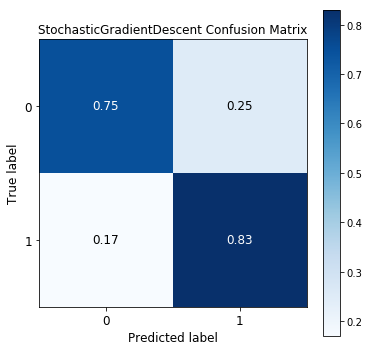

In [17]:
param_grid ={'loss':["hinge","log","modified_huber","epsilon_insensitive","squared_epsilon_insensitive"]
            }

grid = GridSearchCV(SGDClassifier(),
                    param_grid,cv=cv, scoring=scoring,
                    verbose=1)

grid.fit(X_train, y_train)
save(grid, "StochasticGradientDescent")

# Decision Trees
<a id="Tree"></a>
I like to think of decision trees as optimizing a series of “If/Then” statements, eventually assigning the value at the tree’s terminal node. Starting from one point at the top, features can then pass the various trials until being assigned its class at the end “leaf” nodes of the tree (technically, it's more like its root tip since the end nodes are visually represented at the bottom of the graph). Trees used here are binary trees, so nodes can only split into two ways.

In [18]:
# Helper Function to visualize feature importance
predictors = [x for x in X.columns if x not in ['Survived']]
def feature_imp(model):
    MO = model.fit(X_train, y_train)
    feat_imp = pd.Series(MO.feature_importances_, predictors).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [19]:
DecisionTreeClassifier().get_params().keys()

dict_keys(['min_weight_fraction_leaf', 'splitter', 'min_impurity_decrease', 'max_depth', 'criterion', 'presort', 'min_samples_split', 'max_features', 'min_impurity_split', 'class_weight', 'max_leaf_nodes', 'min_samples_leaf', 'random_state'])

## Introduction to Feature Importance Graphic
<a id="FIG"></a>
Since each split in the decision tree distinguishes the dependent variable, splits closer to the root, aka starting point, have optimally been determined to have the greatest splitting effect. The feature importance graphic measures how much splitting impact each feature has. It is important to note that this by no means points to causality, but just like in hierarchical clustering, does point to a nebulous groups. Furthermore, for ensemble tree methods, feature impact is aggregated over all the trees. 

Mean CV Accuracy: 0.751955307263


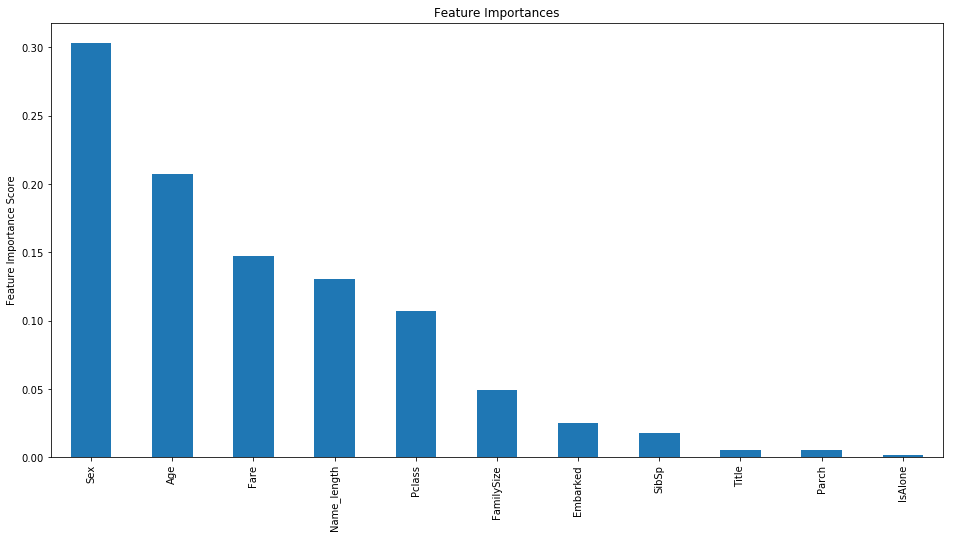

In [20]:
# Baseline Decision Tree
tree = DecisionTreeClassifier()
print("Mean CV Accuracy:",cross_val_score(tree, X, y, cv=cv, scoring=scoring).mean())
feature_imp(tree)

In [21]:
f, ax = plt.subplots(figsize=(9, 6))
s = sns.heatmap(pd.crosstab(train_df.Sex, train_df.Title),
            annot=True, fmt="d", linewidths=.5, ax=ax,
                cbar_kws={'label': 'Count'})
s.set_title('Title Count by Sex Crosstab Heatmap')
s.set_xticklabels(["Mr","Mrs","Miss","Master","Rare"]);

# Ensemble Methods for Decision Trees
<a id="EMDT"></a>

Technique where multiple trees are created and then asked to come together and vote on the model’s outcome. Later in this notebook, this same idea is applied to bring together models of different types.

The sub categories **Boosting** and **Bootstrap Aggregating** are part of this framework, but differ in terms of how the group of trees are *trained*.

## General Hyper-Parameters for Decision Trees and their Ensembles:
 *Sklearn implementation, but universal theory/parameters*

HyperParameters for Tuning:
- max_features: This is the random subset of features to be considered for splitting operation, the lower the better to reduce variance. For Classification model, ideal max_features = sqr(n_var). 
- max_depth: Maximum depth of the tree. Alternate method of control model depth is *max_leaf_nodes*, which limits the number of terminal nodes, effectively limiting the depth of the tree.
- n_estimators: Number of trees built before average prediction is made.
- min_samples_split: Minimum number of samples required for a node to be split. Small minimum would potentially lead to a “Bushy Tree”, prone to overfitting. According to Analytic Vidhya, should be around 0.5~1% of the datasize.
- min_samples_leaf: Minimum number of samples required at the **Terminal Node** of the tree. In Sklearn, an alternative *min_weight_fraction_leaf* is available to use fraction of the data instead of a fixed integer.
- random_state: Ensuring consistent random generation, like seed(). Important to consider for comparing models of the same type to ensure a fair comparison. May cause overfitting if random generation is not representative.

### Quality of Life:
n_jobs: Computer processors utilized. -1 signifies use all processors
Verbose: Amount of tracking information printed. 0 = None, 1 = By Cross Validation, 1 < by tree.

## Bootstrap aggregating (AKA Bagging) Decision Trees
<a id="Bootstrap"></a>

Creates a bunch of trees using a subset of the the data for each, while using sampling without replacement, which means that values may be sampled multiple times. When combined with cross-validation, the values not sampled, or “held-out”, can then be used as the validation set. This results in a better generalizing model: Less prone to overfitting while maintaining a high model capacity (synonymous with model complexity and flexibility).

This technique introduces a flavor of the Monte Carlo method, which hopes to achieve better accuracy through sampling.

Reading:
[Tuning the parameters of your Random Forest model by Analtyics Vidhya](https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/)

Fitting 5 folds for each of 65 candidates, totalling 325 fits


[Parallel(n_jobs=1)]: Done 325 out of 325 | elapsed:  5.9min finished



Evaluation Method: accuracy
Optimal Model Parameters: {'n_estimators': 736}
Train CV Accuracy: 0.78 (+/- 0.06) [Bagger_ensemble]
Test_Score: 0.813432835821


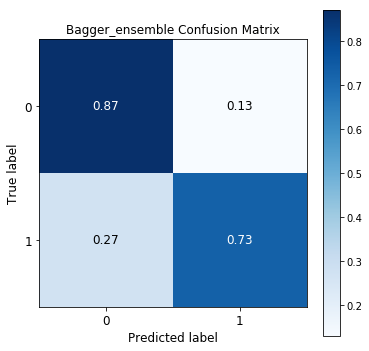

In [22]:
# Parameter Tuning
param_grid ={'n_estimators': n_tree_range}

tree = DecisionTreeClassifier()
grid = RandomizedSearchCV(BaggingClassifier(tree),
                    param_grid, cv=cv, scoring=scoring,
                    verbose=1,n_iter=n_iter, random_state=rstate)

grid.fit(X_train, y_train)
save(grid, "Bagger_ensemble")

## Random Forest
<a id="RandomForest"></a>
Builds upon Leo Breiman's Bootstrap Aggregation method by adding a random feature selection dimension. 
More uncorrelated splits, less overemphasis on certain features. Similar to Neural Net’s dropout, since it forces the model to give a large role to less dominant features, leading to a better generalizing model. However, it differs from dropout in the sense that its effect is not repeated and passed over to future iterations of the training process.

Mean CV Accuracy: 0.817877094972


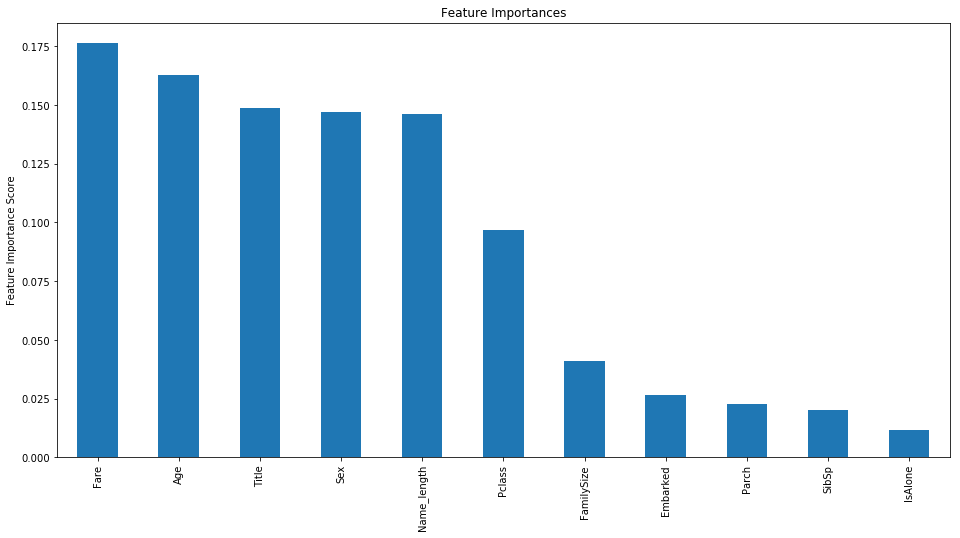

In [23]:
model = RandomForestClassifier()
print("Mean CV Accuracy:",cross_val_score(model, X, y, cv=cv, scoring=scoring).mean())
feature_imp(model)

In [24]:
RandomForestClassifier().get_params().keys()

dict_keys(['oob_score', 'min_weight_fraction_leaf', 'min_impurity_decrease', 'max_depth', 'criterion', 'warm_start', 'n_estimators', 'n_jobs', 'min_samples_split', 'max_features', 'bootstrap', 'class_weight', 'max_leaf_nodes', 'min_samples_leaf', 'random_state', 'min_impurity_split', 'verbose'])

Fitting 5 folds for each of 65 candidates, totalling 325 fits


[Parallel(n_jobs=1)]: Done 325 out of 325 | elapsed:  4.6min finished



Evaluation Method: accuracy
Optimal Model Parameters: {'max_depth': 9, 'max_leaf_nodes': 9, 'n_estimators': 802, 'max_features': 0.55000000000000004}
Train CV Accuracy: 0.83 (+/- 0.03) [Random_Forest]
Test_Score: 0.839552238806


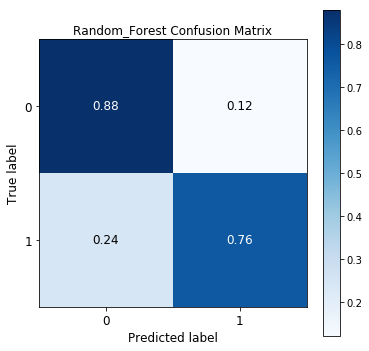

In [25]:
param_grid ={'max_depth': st.randint(6, 11),
             'n_estimators': n_tree_range,
             'max_features':np.arange(0.5,.81, 0.05),
            'max_leaf_nodes':st.randint(6, 10)}

model= RandomForestClassifier()

grid = RandomizedSearchCV(model,
                    param_grid, cv=cv,
                    scoring=scoring,
                    verbose=1,n_iter=n_iter, random_state=rstate)

grid.fit(X_train, y_train)
save(grid, "Random_Forest")

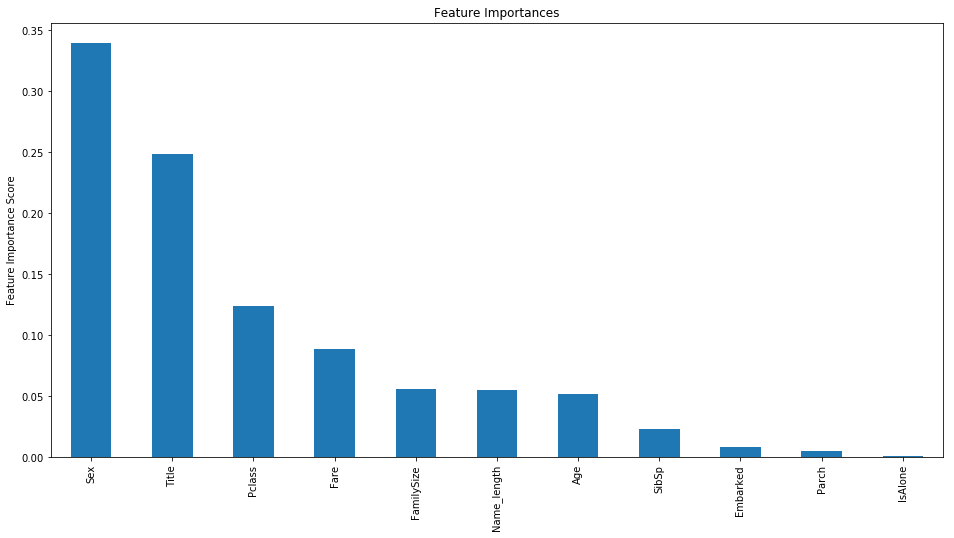

In [26]:
feature_imp(grid.best_estimator_)

## Boosting Family
Simply put, boosting models convert weak models into strong models. Essentially, each weak model is trained on a different distribution of the data, enabling it to learn a narrow rule. When combined, it offers a stronger model. Iteratively, subsequent weak models focus on the source of prediction error from the vote of previous weak models, until the accuracy ceiling is reached.

Source:
[Quick Introduction to Boosting Algorithms in Machine Learning by Analytics Vidhya](https://www.analyticsvidhya.com/blog/2015/11/quick-introduction-boosting-algorithms-machine-learning/)

## Adaptive Boosting
<a id="Adaboost"></a>

Applies weights to all data points and optimizes them using the loss function. Fixes mistakes by assigning high weights to them during iterative process.

Iterates through multiple models in order to determine the best boundaries. It relies on using weak models to determine the pattern, and eventually creates a strong combination of them.

In [27]:
AdaBoostClassifier().get_params().keys()

dict_keys(['base_estimator', 'learning_rate', 'algorithm', 'n_estimators', 'random_state'])

Fitting 5 folds for each of 65 candidates, totalling 325 fits


[Parallel(n_jobs=1)]: Done 325 out of 325 | elapsed:  4.8min finished



Evaluation Method: accuracy
Optimal Model Parameters: {'learning_rate': 0.10000000000000001, 'n_estimators': 730}
Train CV Accuracy: 0.82 (+/- 0.01) [AdaBoost_Ensemble]
Test_Score: 0.794776119403


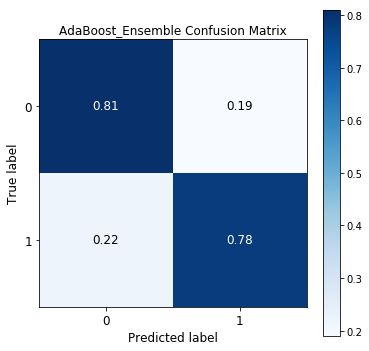

In [28]:
param_grid ={'n_estimators':n_tree_range,
            'learning_rate':np.arange(.1, 4, .5)}

grid = RandomizedSearchCV(AdaBoostClassifier(),
                    param_grid,cv=cv, scoring=scoring,
                    verbose=1, n_iter=n_iter, random_state=rstate)

grid.fit(X_train, y_train)
save(grid, "AdaBoost_Ensemble")

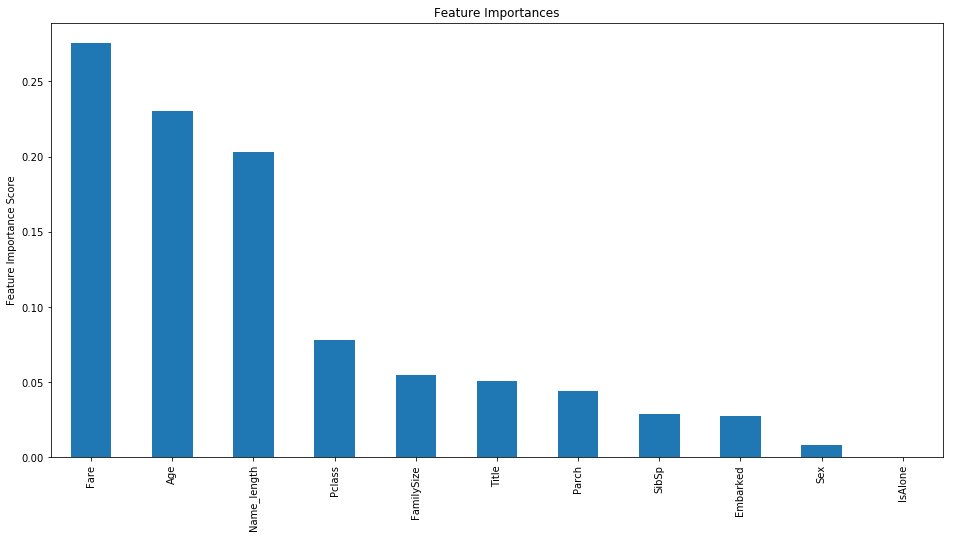

In [29]:
feature_imp(grid.best_estimator_)


## Gradient Boosting Classifier
<a id="Gradient Boost"></a>

### Additional Gradient Boosting Hyper-Parameters:
Learning_rate: How much parameters are updated after each iteration of gradient descent. Low mean smaller steps, most likely to reach the global minimum, although there are cases where this doesn’t always work as intended.
N_estimators: Note this is still the number of trees being built, but it within the GBC’s sequential methodology.
Subsample: Similar to the Bootstrap Aggregate method, controlling percentage of data utilized for a tree, although the standard is to sample *without* replacement. In this model, operates in similar ways to Stochastic Gradient Descent in Neural Networks, but with large batch sizes. Note this decision trees are still a *Shallow Model*, so it is still profoundly different from Neural Networks.
Loss: Function minimized by gradient descent.
Init: Initialization of the model internal parameters. May be used to build off another model's’ outcome.

As the name suggest, Gradient Boosting iteratively trains models sequentially to minimize Loss, a convex optimization method similar to that seen in Neural Networks.

[Gradient boosting machines, a tutorial by Alexey Natekin1 and Alois Knoll](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3885826/)

This is a Greedy Algorithm, which makes the most favorable split when it can. This means it's short sighted and will also stop when the loss doesn’t improve.

More information:

[Complete Guide to Parameter Tuning in Gradient Boosting (GBM) in Python by Analytics Vidhya](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/)

In [30]:
GradientBoostingClassifier().get_params().keys()

dict_keys(['subsample', 'learning_rate', 'init', 'min_impurity_decrease', 'min_weight_fraction_leaf', 'max_depth', 'criterion', 'warm_start', 'n_estimators', 'presort', 'loss', 'min_samples_split', 'max_features', 'min_impurity_split', 'max_leaf_nodes', 'min_samples_leaf', 'random_state', 'verbose'])

Fitting 5 folds for each of 65 candidates, totalling 325 fits


[Parallel(n_jobs=1)]: Done 325 out of 325 | elapsed:  1.9min finished



Evaluation Method: accuracy
Optimal Model Parameters: {'max_depth': 2.5, 'loss': 'deviance', 'learning_rate': 0.060000000000000005, 'n_estimators': 859}
Train CV Accuracy: 0.78 (+/- 0.03) [Gradient_Boosting]
Test_Score: 0.820895522388


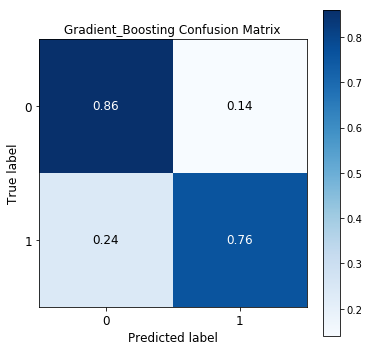

In [31]:
param_grid ={'n_estimators': n_tree_range,
            'loss': ['deviance', 'exponential'],
            'learning_rate':np.arange(0.01, 0.32,.05),
            'max_depth': np.arange(2, 4.1, .5)}

grid = RandomizedSearchCV(GradientBoostingClassifier(),
                    param_grid,cv=cv,
                    scoring=scoring,
                    verbose=1, n_iter=n_iter, random_state=rstate)

grid.fit(X_train, y_train)
save(grid, "Gradient_Boosting")

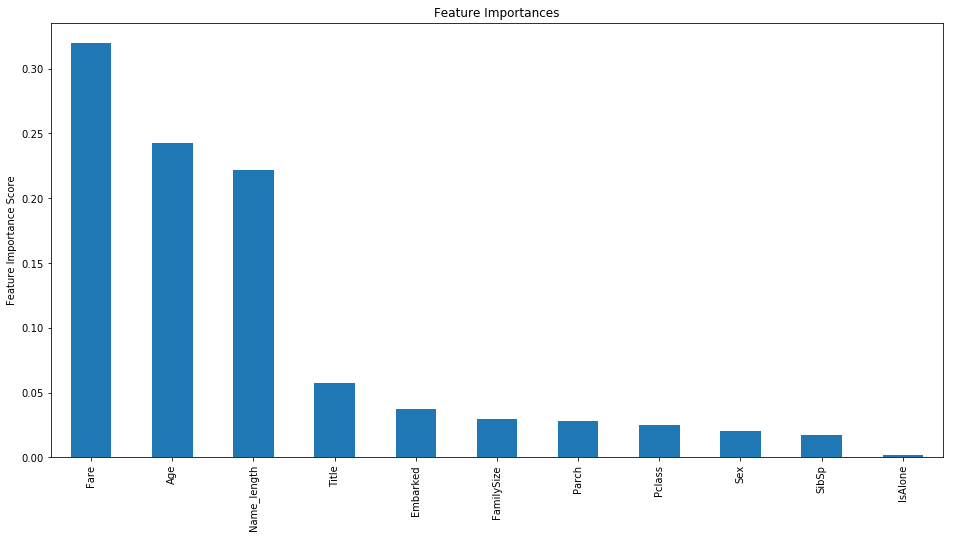

In [32]:
feature_imp(grid.best_estimator_)

## XGBoost - eXtreme Gradient Boosting
<a id="XGBOOST"></a>
As the name suggest, Gradient Boosting on steroids. Infact, multiple steroids:
Regularization
Computation Speed and Parallel Processing
Handles Missing Values
Improves on Gradient Boosting ‘*Greedy*’ tendencies. It does this by considering reaching the max depth and retroactively pruning 
Interruptible and Resumable, as well as Hadoop capabilities.

XGBoost is able to approximate the Loss function more efficiently, thereby leading to faster computation and parallel processing. Inside its objective function, it has also incorporated a regularization term, ridge or lasso, to stay clear of unnecessary high dimensional spaces and complexity.

### Hyper-Parameters for Tree Classification Booster (Sklearn Wrapper)
Min_child_weight: Similar strand to *min_child_leaf*, which controls the minimum number of observation to split to a terminal node. This instead relates to defines the minimum sum of derivatives found in the Hessian (second-order)of all observations required in a child.
Gamma: Node is split only if it gives a positive decrease in the loss function. Higher performance regulator of complexity.
Max_delta_step: What the tree’s weights can be.
Colsample_bylevel: Random Forest characteristic, where it enables subfraction of features to be randomly selected for each tree.

### Regularization
In the context of GBMs, regularization through shrinkage is available, but applying it to the model with the tree base-learner is different from its traditional coefficient constriction. For GBM Trees, the shrinking decreases the influence of each additional tree in the iterative process, effectively applying a decay of impact over boosting rounds. As a result, it no longer searches as the feature selection method, since it cannot adjust the coefficients of each feature (and potential interaction/ polynomial terms).


### Learning Task Parameters:
Objective: binary:logistic = Outputs probability for two classes. Multi:softmax = outputs prediction for *num_class* classes. Multi:prob = probability for 3 or more classes.
The objective is merely a matter of catering to the data type, although additional protocols on the probabilities may be set up. For example, the highest probability below a certain threshold may be deemed an inadequate score, passed over for human processing. The optimal loss function should cater to the behavior of the data and goal at hand, and usually requires input from the domain knowledge base.

The Evaluation Metric (*eval_metric*) has important implications depending on the problem at hand. If the dataset is imbalanced and the minority class is of interest, it is better to use [AUC] Area Under the Curve than accuracy or rmse, since those metrics can get away with assigning the majority class to all, and still get away with high accuracy!


More Info:
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/


Python Installation: https://www.ibm.com/developerworks/community/blogs/jfp/entry/Installing_XGBoost_For_Anaconda_on_Windows?lang=en

In [33]:
XGBClassifier().get_params().keys()

dict_keys(['reg_lambda', 'learning_rate', 'objective', 'scale_pos_weight', 'min_child_weight', 'max_depth', 'colsample_bylevel', 'nthread', 'n_estimators', 'missing', 'max_delta_step', 'colsample_bytree', 'reg_alpha', 'gamma', 'booster', 'n_jobs', 'seed', 'base_score', 'random_state', 'subsample', 'silent'])

Fitting 3 folds for each of 65 candidates, totalling 195 fits


[Parallel(n_jobs=1)]: Done 195 out of 195 | elapsed:   49.2s finished



Evaluation Method: accuracy
Optimal Model Parameters: {'colsample_bytree': 0.87131674191566333, 'learning_rate': 0.01, 'gamma': 2.8809577788923795, 'reg_alpha': 0, 'max_depth': 4, 'subsample': 0.80308878420453766, 'n_estimators': 634}
Train CV Accuracy: 0.82 (+/- 0.03) [Sci_kit XGB]
Test_Score: 0.813432835821


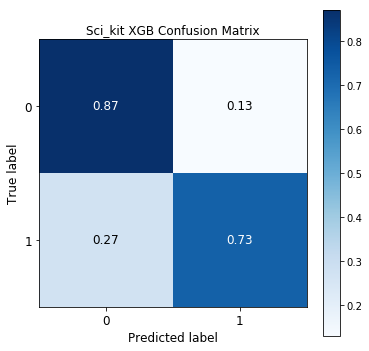

In [34]:
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": n_tree_range,
    "max_depth": st.randint(2, 8),
    "learning_rate": [0.01],
    #'max_features':'sqrt',
    #"learning_rate": st.uniform(0.001, 0.1),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 3),
    #'reg_alpha': from_zero_positive,
    #"min_child_weight": from_zero_positive,
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}

xgbreg = XGBClassifier(objective= 'binary:logistic', eval_metric="auc",
                       nthreads=2)

grid = RandomizedSearchCV(xgbreg, params, n_jobs=1, verbose=1, n_iter=n_iter,
                          random_state=rstate, scoring=scoring)  
grid.fit(X_train,y_train, verbose=False)
save(grid, "Sci_kit XGB")

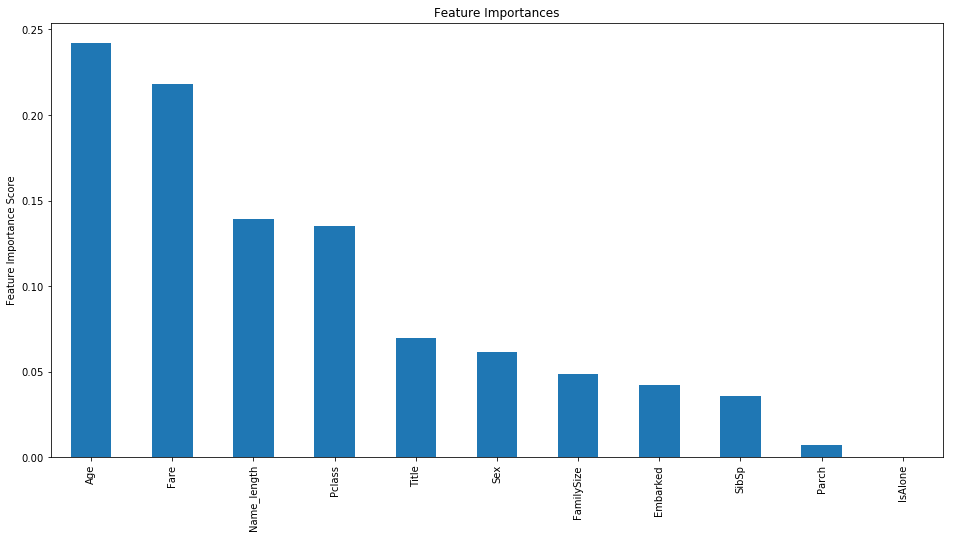

In [35]:
feature_imp(grid.best_estimator_)

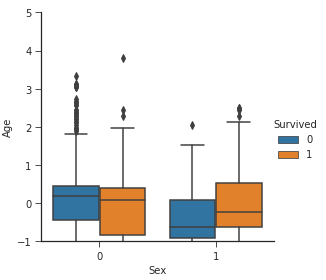

In [36]:
# What is going on with Age, Sex and Survival?
with sns.axes_style(style='ticks'):
    g = sns.factorplot("Sex", "Age", "Survived", data=train_df, kind="box")
    g.set(ylim=(-1,5))
    g.set_axis_labels("Sex", "Age");

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=25, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       scoring='accuracy', seed=None, silent=True, subsample=1)

xgBoost - CV Train : 0.82
xgBoost - Train : 0.83
xgBoost - Test : 0.81

Evaluation Method: accuracy
Train CV Accuracy: 0.82 (+/- 0.04) [XGBsklearn]
Test_Score: 0.876865671642


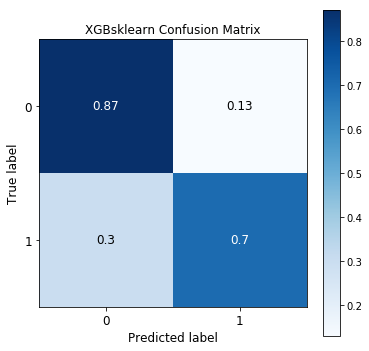

In [37]:
model = XGBClassifier(n_estimators = num_rounds,
                        objective= 'binary:logistic',
                     learning_rate=0.01, random_state=rstate, scoring=scoring)

# use early_stopping_rounds to stop the cv when there is no score imporovement
model.fit(X_train,y_train, early_stopping_rounds=20, eval_set=[(X_test,
y_test)], verbose=False)
score = cross_val_score(model, X_train,y_train, cv=cv)
print(model)
print("\nxgBoost - CV Train : %.2f" % score.mean())
print("xgBoost - Train : %.2f" % metrics.accuracy_score(model.predict(X_train), y_train))
print("xgBoost - Test : %.2f" % metrics.accuracy_score(model.predict(X_test), y_test))
norm_save(model,score, "XGBsklearn")

## XGBoost Package Implementation

Optimal number of trees/estimators is 54
[0]	test-error:0.179104	train-error:0.168539
[1]	test-error:0.190299	train-error:0.162119
[2]	test-error:0.171642	train-error:0.157303
[3]	test-error:0.175373	train-error:0.150883
[4]	test-error:0.179104	train-error:0.147673
[5]	test-error:0.179104	train-error:0.149278
[6]	test-error:0.179104	train-error:0.149278
[7]	test-error:0.179104	train-error:0.149278
[8]	test-error:0.179104	train-error:0.149278
[9]	test-error:0.190299	train-error:0.146067
[10]	test-error:0.19403	train-error:0.144462
[11]	test-error:0.190299	train-error:0.138042
[12]	test-error:0.182836	train-error:0.136437
[13]	test-error:0.186567	train-error:0.128411
[14]	test-error:0.190299	train-error:0.125201
[15]	test-error:0.190299	train-error:0.125201
[16]	test-error:0.186567	train-error:0.123596
[17]	test-error:0.186567	train-error:0.123596
[18]	test-error:0.19403	train-error:0.12199
[19]	test-error:0.197761	train-error:0.123596
[20]	test-error:0.190299	train-error:0.123596
[21]	t

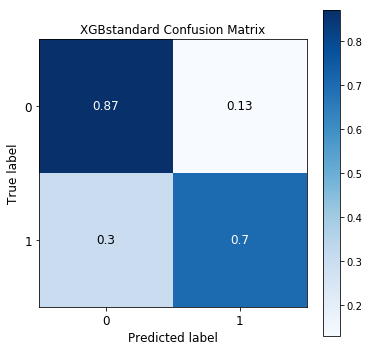

In [38]:
xgtrain = xgb.DMatrix(X_train, label=y_train)
xgtest = xgb.DMatrix(X_test, label=y_test)

# set xgboost params
param = {'max_depth': 3,  # the maximum depth of each tree
         'objective': 'binary:logistic'}

clf_xgb_cv = xgb.cv(param, xgtrain, num_rounds, 
                    stratified=True, 
                    nfold=n_splits, 
                    early_stopping_rounds=20)
print("Optimal number of trees/estimators is %i" % clf_xgb_cv.shape[0])

watchlist  = [(xgtest,'test'), (xgtrain,'train')]                
clf_xgb = xgb.train(param, xgtrain,clf_xgb_cv.shape[0], watchlist)

# predict function will produce the probability 
# so we'll use 0.5 cutoff to convert probability to class label
y_train_pred = (clf_xgb.predict(xgtrain, ntree_limit=clf_xgb.best_iteration) > 0.5).astype(int)
y_test_pred = (clf_xgb.predict(xgtest, ntree_limit=clf_xgb.best_iteration) > 0.5).astype(int)
score= metrics.accuracy_score(y_test_pred, y_test)
print("\nXGB - CV Train : %.2f" % score)
print("XGB - Train : %.2f" % metrics.accuracy_score(y_train_pred, y_train))
norm_save(model,score, "XGBstandard")

# Parametric Models
<a id="Parametric"></a>
Family of models which makes assumption of the underlying distribution, and attempts to build models on top of it with a fixed number of parameters. Works great when they're assumption is correct and the data behaves itself.

# Parametric Discriminative Models
I want to take this opportunity to elaborate a bit more on the discriminative/generative dichotomy. An interesting observation by Andrew Ng is that while discriminative classifiers can reach a higher accuracy cap (asymptotic error), it achieves it at a slower rate than its generative counterpart. He does this by comparing *Naive Bayes* and *Logistic Regression*, two generative models. Therefore, for computational and goal solving reasons, it is best to solve for the conditional probability of p(x|y) directly, instead of trying to compute their joint distribution as seen in generative models.
 
Source: https://ai.stanford.edu/~ang/papers/nips01-discriminativegenerative.pdf

# Logistic Regression
<a id="Logistic"></a>
The classification regression. In the binary classification problem, the classic linear regression is unable to bound itself between classes [0,1]. So the logistic regression uses the logit from the sigmoid function, which transformed the weighted input into a probability of class being “1”. Although not the best performer, if offers exploratory information and can potentially reveal causal information, if the experiment is setup correctly.


Evaluation Method: accuracy
Train CV Accuracy: 0.81 (+/- 0.03) [Logistic_Regression]
Test_Score: 0.80223880597


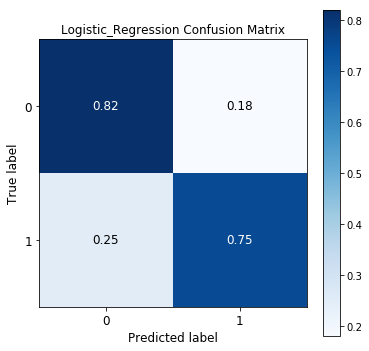

In [39]:
model= LogisticRegression()
score = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
norm_save(LogisticRegression(),score, "Logistic_Regression")

In [40]:
import statsmodels.api as sm

logit = sm.Logit(y, X) # fit the model
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.423094
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      880
Method:                           MLE   Df Model:                           10
Date:                Tue, 23 Jan 2018   Pseudo R-squ.:                  0.3646
Time:                        20:25:14   Log-Likelihood:                -376.98
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                 1.020e-86
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Pclass         -0.9582      0.149     -6.423      0.000      -1.251      -0.666
Sex             1.9484      0.250      7.803      0.000       1.459       2.438
Age            -0.4411      0.111     -3.984      0.000      -0.658      -0.224
SibSp          -1.7454      0.558     -3.125      0.002      -2.840      -0.651
Parch          -1.4893      0.532     -2.801      0.005      -2.532      -0.447
Fare            0.1627      0.129      1.261      0.207      -0.090       0.416
Embarked        0.1662      0.191      0.868      0.385      -0.209       0.541
FamilySize      1.1333      0.494      2.296      0.022       0.166       2.101
Name_length     0.3366      0.115      2.926      0.003       0.111       0.562
IsAlone        -0.5798      0.294     -1.972      0.049      -1.156      -0.004
Title           0.4498      0.117      3.856      0.000       0.221       0.678
===============================================================================
"""

# Feedforward Neural Networks
<a id="FNN"></a>
The only “Deep Model” out of the mix. This is a characteristic of *Representation Learning*, which effectively grants the model its own feature processing and selection steps, catering to large, complex data with intertwining effects. In computer vision tasks, the convolutional neural networks is able to piece apart corners, colors, patterns and more. Recent research in Style Transfer even suggests that stylistic properties of a picture, such as art, can be extracted, and controlled.  
Source: https://arxiv.org/abs/1611.07865

A common explanation for Neural Networks is that it is a whole bunch of Logistic Regressions. An important thing to remembers is that the hidden-layers are fully connected, meaning that each input variables has a weight to each node (hidden-unit) in the hidden layer, thereby resulting in a black box with a whole lot of parameters, and a whole lot of matrix multiplications. Finally it's, ironic that one of the most intelligible classifiers can be transformed into the least intelligible! In *Computer Age Statistical Inference* authors Bradley Efron and Trevor Hastie are hopeful for the next Ronald Fisher to come and provide statistical intelligibility to modern day machine learning models, many of which are highly developed computationally, but lacking inferential theory.

Model not ideal for such as small dataset.

In [41]:
MLPClassifier().get_params().keys()

dict_keys(['alpha', 'early_stopping', 'learning_rate', 'beta_1', 'solver', 'beta_2', 'nesterovs_momentum', 'learning_rate_init', 'hidden_layer_sizes', 'power_t', 'shuffle', 'warm_start', 'tol', 'activation', 'momentum', 'validation_fraction', 'max_iter', 'epsilon', 'batch_size', 'random_state', 'verbose'])

Fitting 5 folds for each of 65 candidates, totalling 325 fits


[Parallel(n_jobs=1)]: Done 325 out of 325 | elapsed:    8.2s finished



Evaluation Method: accuracy
Optimal Model Parameters: {'alpha': 100, 'early_stopping': True, 'learning_rate': 'adaptive', 'activation': 'identity', 'max_iter': 35938, 'hidden_layer_sizes': 1000}
Train CV Accuracy: 0.66 (+/- 0.04) [FFNeural_Net]
Test_Score: 0.720149253731


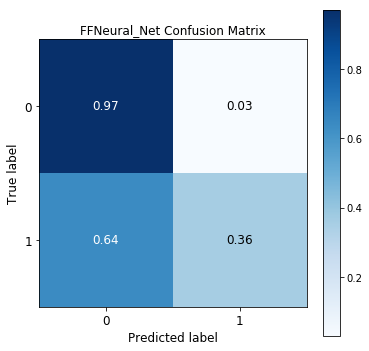

In [42]:
# Start with a RandomSearchCV to efficiently Narrow the Ballpark
param_grid ={'max_iter': np.logspace(1, 5, 10).astype("int32"),
             'hidden_layer_sizes': np.logspace(2, 3, 4).astype("int32"),
             'activation':['identity', 'logistic', 'tanh', 'relu'],
             'learning_rate': ['adaptive'],
             'early_stopping': [True],
             'alpha': np.logspace(2, 3, 4).astype("int32")
            }

model = MLPClassifier()
grid = RandomizedSearchCV(model,
                    param_grid, cv=cv, scoring=scoring,
                    verbose=1, n_iter=n_iter, random_state=rstate)

grid.fit(X_train, y_train)
save(grid, "FFNeural_Net")

# Support Vector Classifier
<a id="SVC"></a>
Another model originating in Computer Science, the Support Vector Classifier creates a separation between point to determine class. Maximizing the accuracy of the discriminatory protocol.

### Hyperparameters:
- C: Rigidity and size of the separation line margin. Increasing C leads to a smaller, thus a more complex mode, and everything that comes with it (High variance, Low Bias)!

## Linear Classifier:
<a id="LSVC"></a>
In this case, the separator is linear. Imagine a two dimensional plot with a straight line separating two classes of points, but efficiently scalable up to a high dimensional space (plane, cube… hypercube :-O ? )

In [43]:
LinearSVC().get_params().keys()

dict_keys(['penalty', 'C', 'dual', 'intercept_scaling', 'tol', 'loss', 'multi_class', 'max_iter', 'class_weight', 'fit_intercept', 'random_state', 'verbose'])


Evaluation Method: accuracy
Train CV Accuracy: 0.80 (+/- 0.03) [LinearSV]
Test_Score: 0.828358208955


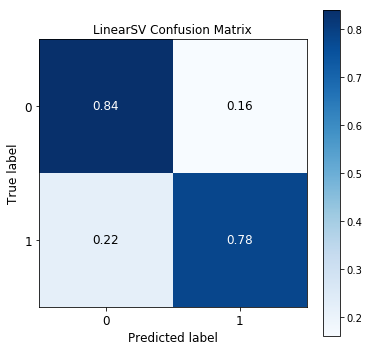

In [44]:
# Define Model
model = LinearSVC()

#Fit Model
scores= cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
norm_save(model, scores, "LinearSV")

## Radial Basis Function (RBF)
<a id="RBF"></a>
Here, not only are non-linear boundaries available, the kernel trick is aso introduced, which enables new representations of the data to be formulated, effectively granting the models new dimensions to find better separators in.

### Hyperparameter:
- Gamma: How far the influence of a single training example reaches, and sort of like a soft boundary with a gradient. 
- Low Gamma -> Distant fit, High Gamma = Close Fit, Inverse of the radius of influence of samples selected by the model as support vectors.
http://pages.cs.wisc.edu/~yliang/cs760/howtoSVM.pdf

In [45]:
SVC().get_params().keys()

dict_keys(['cache_size', 'C', 'kernel', 'decision_function_shape', 'coef0', 'tol', 'shrinking', 'degree', 'gamma', 'max_iter', 'class_weight', 'probability', 'random_state', 'verbose'])

Fitting 5 folds for each of 65 candidates, totalling 325 fits


[Parallel(n_jobs=1)]: Done 325 out of 325 | elapsed:  1.1min finished



Evaluation Method: accuracy
Optimal Model Parameters: {'svc__gamma': 0.00035938136638046257, 'svc__C': 5535}
Train CV Accuracy: 0.82 (+/- 0.03) [SVCrbf]
Test_Score: 0.835820895522


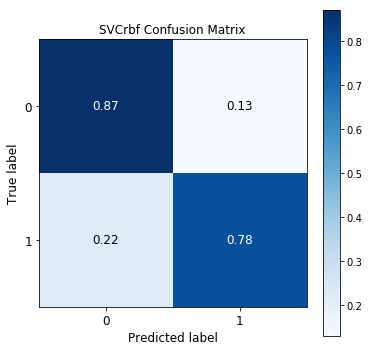

In [46]:
svc = SVC(kernel= 'rbf', probability=True)

model = Pipeline(steps=[('svc', svc)])


param_grid = {'svc__C': st.randint(1,10000),
              'svc__gamma': np.logspace(1, -7, 10)}

grid = RandomizedSearchCV(model, param_grid,
                          cv=cv, verbose=1, scoring=scoring,
                         n_iter=n_iter, random_state=rstate)

grid.fit(X_train, y_train)
save(grid, "SVCrbf")

## Pipeline and Principal Components Analysis and Support Vector Classifier
<a id="PCA"></a>
Pipelines enable multiple models or processes to be chained up and hyper-parameter tuned together. Very powerful tool, especially when uncertain about a model's reaction to processed data, since it may reveal complex, high performing combinations.

### Limitations:
The radial basis function support vector machine is actually able to leverage high dimensional data through its *kernel trick* to improve performance. For these reasons, it may not actually benefit from this procedure. 

### Dimensionality Reduction: Principal Component Analysis
Decreases the noise by condensing the features into the dimensions of most variance. 

Fitting 5 folds for each of 65 candidates, totalling 325 fits


[Parallel(n_jobs=1)]: Done 325 out of 325 | elapsed:  1.2min finished



Evaluation Method: accuracy
Optimal Model Parameters: {'svc__gamma': 0.0027825594022071257, 'svc__C': 7683, 'pca__n_components': 7}
Train CV Accuracy: 0.81 (+/- 0.02) [PCA_SVC]
Test_Score: 0.835820895522


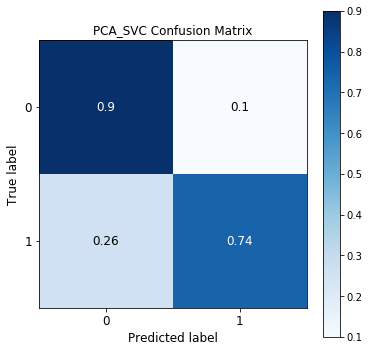

In [47]:
pca = PCA()
svc = SVC(kernel= 'rbf',probability=True)

model = Pipeline(steps=[('pca',pca),
                        ('svc', svc)])


param_grid = {'svc__C': st.randint(1,10000),
              'svc__gamma': np.logspace(1, -7, 10),
             'pca__n_components': st.randint(1,len(X.columns))}

grid = RandomizedSearchCV(model, param_grid,
                          cv=cv, verbose=1,
                         n_iter=n_iter, random_state=rstate, scoring=scoring)

grid.fit(X_train, y_train)
save(grid, "PCA_SVC")

# Parametric Generative Classification
<a id="GPM"></a>
Models the data generating process in order to assign which categorize the features. Process is represented in terms of joint probabilities. Advantageous since it can be used to generate features, but tends to struggle in terms of accuracy and doesn’t scale well into tall and wide datasets. Only Gaussian Bayes used in this category, but additional Generative Models can be explored, such as:

Hidden Markov model
Probabilistic context-free grammar
Averaged one-dependence estimators
Latent Dirichlet allocation
Restricted Boltzmann machine
Generative adversarial networks

## Gaussian Naive Bayes
<a id="GNB"></a>
Through Bayes rule, is able to use conditional probabilities to classify data. Predicts the class by finding the one with the highest Posterior.

### Interpretation:
After I increased the feature space through feature engineering, model performance dropped from 75% to worst than random. Furthermore, this model gambles that most passengers died. Only thing going for it is its low false negative rate..


Evaluation Method: accuracy
Train CV Accuracy: 0.80 (+/- 0.04) [Gaussian]
Test_Score: 0.794776119403


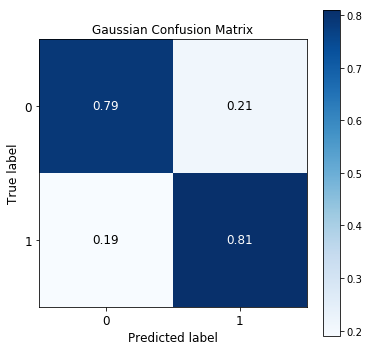

In [48]:
model = GaussianNB()

score = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
norm_save(model,score, "Gaussian")

## Results

In [49]:
results = results.sort_values(by=["CV Mean"], ascending=False)
results

,Model,Para,Test_Score,CV Mean,CV STDEV
3,Random_Forest,"{'max_depth': 9, 'max_leaf_nodes': 9, 'n_estim...",0.839552,0.829698,0.032009
12,SVCrbf,"{'svc__gamma': 0.00035938136638, 'svc__C': 5535}",0.835821,0.824872,0.032909
6,Sci_kit XGB,"{'colsample_bytree': 0.871316741916, 'learning...",0.813433,0.823350,0.030895
7,XGBsklearn,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.876866,0.820800,0.040980
4,AdaBoost_Ensemble,"{'learning_rate': 0.1, 'n_estimators': 730}",0.794776,0.818550,0.013987
13,PCA_SVC,"{'svc__gamma': 0.00278255940221, 'svc__C': 768...",0.835821,0.813724,0.021853
8,XGBstandard,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.876866,0.813433,0.000000
9,Logistic_Regression,"LogisticRegression(C=1.0, class_weight=None, d...",0.802239,0.809600,0.031759
11,LinearSV,"LinearSVC(C=1.0, class_weight=None, dual=True,...",0.828358,0.804800,0.027058
0,KNN,"{'n_neighbors': 20, 'weights': 'distance'}",0.791045,0.804072,0.026447


# Classification Voting: Model Ensemble
<a id="Vote"></a>
Like the system that enabled multiple trees to predict together, this system brings together models of all types. A broader implementation.

- **Hard Voting:** Plurality voting over the classes.
- **Soft Voting:** Selects classed based off aggregated probabilities over the models. Requires model with probabilistic capabilities, which is why I removed linear SCV from inclusion. This difference is tremendous, while hard votes may polarize a small difference between models, say the prediction of 51% Survived and 49% Dead, the soft voting is able to make a more nuanced decision, rewarding high confidence models, and penalizing low confidence.
- **Weights:** This is an additional feature which enables manual assigning voting power to each voting model.

## Prepare and Observe Voting Models

In [50]:
### Ensemble Voting
not_proba_list = ('LinearSV','StochasticGradientDescent')
not_proba =  results.query("Model in @not_proba_list")
hard_models = results # All Can Be
prob_models = results.query("Model not in @not_proba_list") # Not All
# [x for x in results.Model if x not in not_proba_list]

# Submission DataFrame for correlation purposes
# Hard Output
test_hard_pred_matrix = pd.DataFrame()
train_hard_pred_matrix = pd.DataFrame()

#Soft Output
test_soft_pred_matrix = pd.DataFrame()
train_soft_pred_matrix = pd.DataFrame()

In [51]:
# Only Non-Probabilistic
models = list(zip([ensemble_models[x] for x in not_proba.Model],
                  not_proba.Model))
clfs = []
print('5-fold cross validation:\n')
for clf, label in models:
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring=scoring, verbose=0)
    print("Train CV Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    md = clf.fit(X_train, y_train)    
    clfs.append(md)
    print("Test Accuracy: %0.2f \n" % (metrics.accuracy_score(clf.predict(X_test), y_test)))
    
    # Model on Full Data
    md = clf.fit(X,y)
    submission = md.predict(test_df)
    df = pd.DataFrame({'PassengerId':test_df.index, 
                           'Survived':submission})
    train_hard_pred_matrix = pd.concat((train_hard_pred_matrix, pd.DataFrame({label: md.predict(X)})), axis=1)
    test_hard_pred_matrix = pd.concat((test_hard_pred_matrix, pd.DataFrame({label: submission})), axis=1)
    if save == True:
        df.to_csv("{}.csv".format(label),header=True,index=False)

del clfs

5-fold cross validation:

Train CV Accuracy: 0.80 (+/- 0.03) [LinearSV]
Test Accuracy: 0.82 

Train CV Accuracy: 0.70 (+/- 0.10) [StochasticGradientDescent]
Test Accuracy: 0.71 



5-fold cross validation:

Train CV Accuracy: 0.83 (+/- 0.03) [Random_Forest]
ROC AUC: 0.90
Test Accuracy: 0.84 

Train CV Accuracy: 0.82 (+/- 0.03) [SVCrbf]
ROC AUC: 0.85
Test Accuracy: 0.84 

Train CV Accuracy: 0.82 (+/- 0.03) [Sci_kit XGB]
ROC AUC: 0.89
Test Accuracy: 0.81 

Train CV Accuracy: 0.81 (+/- 0.04) [XGBsklearn]
ROC AUC: 0.89
Test Accuracy: 0.81 

Train CV Accuracy: 0.82 (+/- 0.01) [AdaBoost_Ensemble]
ROC AUC: 0.87
Test Accuracy: 0.79 

Train CV Accuracy: 0.81 (+/- 0.02) [PCA_SVC]
ROC AUC: 0.87
Test Accuracy: 0.84 

Train CV Accuracy: 0.81 (+/- 0.04) [XGBstandard]
ROC AUC: 0.89
Test Accuracy: 0.81 

Train CV Accuracy: 0.81 (+/- 0.04) [Logistic_Regression]
ROC AUC: 0.87
Test Accuracy: 0.79 

Train CV Accuracy: 0.80 (+/- 0.03) [KNN]
ROC AUC: 0.86
Test Accuracy: 0.79 

Train CV Accuracy: 0.81 (+/- 0.04) [Gaussian]
ROC AUC: 0.86
Test Accuracy: 0.80 

Train CV Accuracy: 0.78 (+/- 0.03) [Gradient_Boosting]
ROC AUC: 0.89
Test Accuracy: 0.82 

Train CV Accuracy: 0.78 (+/- 0.05) [Ba

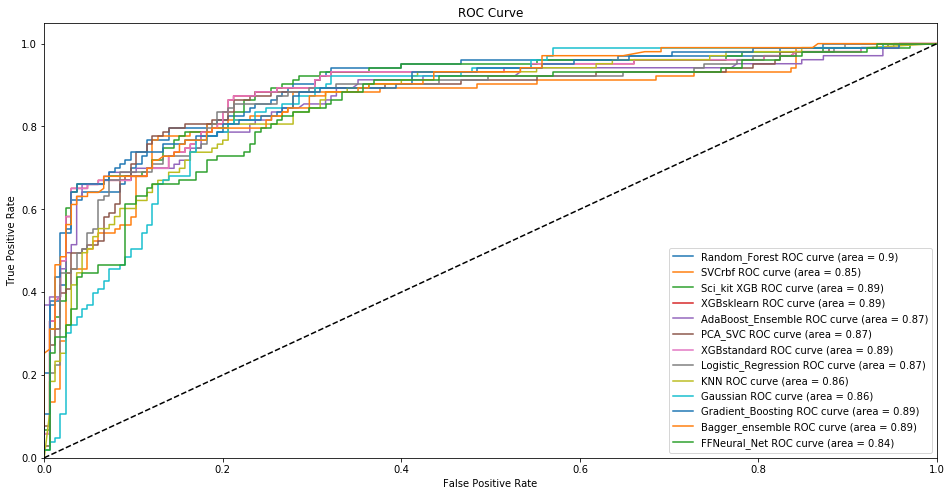

In [52]:
# Only Probabilistic
models = list(zip([ensemble_models[x] for x in prob_models.Model],
                  prob_models.Model))
plt.figure()

print('5-fold cross validation:\n')
clfs = []
for clf, label in models:
    scores = cross_val_score(clf, X_train, y_train,cv=5, scoring=scoring, verbose=0)
    print("Train CV Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    md = clf.fit(X_train, y_train)
    # Add to Roc Curve
    fpr, tpr, _ = roc_curve(y_test, md.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)

    print('ROC AUC: %0.2f' % roc_auc)
    plt.plot(fpr, tpr, label='{} ROC curve (area = {:.2})'.format(label, roc_auc))
    
    clfs.append(md)
    print("Test Accuracy: %0.2f \n" % (metrics.accuracy_score(clf.predict(X_test), y_test)))
    
    # Model on Full Data
    md = clf.fit(X,y)
    submission = md.predict(test_df)
    df = pd.DataFrame({'PassengerId':test_df.index, 
                           'Survived':submission})
    train_hard_pred_matrix = pd.concat((train_hard_pred_matrix, pd.DataFrame({label: md.predict(X)})), axis=1)
    test_hard_pred_matrix = pd.concat((test_hard_pred_matrix, pd.DataFrame({label: submission})), axis=1)

    train_soft_pred_matrix = pd.concat((train_soft_pred_matrix, pd.DataFrame({label: md.predict(X)})), axis=1)
    test_soft_pred_matrix = pd.concat((test_soft_pred_matrix, pd.DataFrame({label: md.predict_proba(test_df)[:,1]})), axis=1)
    if save == True:
        df.to_csv("{}.csv".format(label),header=True,index=False)

# Plot
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Introduction to Receiver Operating Characteristic curve [ROC]
ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. Well said wikipedia. Closer the line is to the top left, the better its predictive ability. Non-Smooth curve suggest important thresholds, effective a cluster of probabilities near a swing point.


# Soft and Hard Voters of Difference Sizes


2-Voting Models: 5-fold cross validation:

Train CV Accuracy: 0.83 (+/- 0.03) [2-VM-Ensemble Soft Voting]
Test Accuracy: 0.84 
ROC AUC: 0.90
Train CV Accuracy: 0.82 (+/- 0.03) [2-VM-Ensemble Hard Voting]
Test Accuracy: 0.84 

3-Voting Models: 5-fold cross validation:

Train CV Accuracy: 0.83 (+/- 0.03) [3-VM-Ensemble Soft Voting]
Test Accuracy: 0.84 
ROC AUC: 0.93
Train CV Accuracy: 0.83 (+/- 0.03) [3-VM-Ensemble Hard Voting]
Test Accuracy: 0.84 

5-Voting Models: 5-fold cross validation:

Train CV Accuracy: 0.84 (+/- 0.03) [5-VM-Ensemble Soft Voting]
Test Accuracy: 0.83 
ROC AUC: 0.93
Train CV Accuracy: 0.83 (+/- 0.02) [5-VM-Ensemble Hard Voting]
Test Accuracy: 0.83 

7-Voting Models: 5-fold cross validation:

Train CV Accuracy: 0.83 (+/- 0.03) [7-VM-Ensemble Soft Voting]
Test Accuracy: 0.82 
ROC AUC: 0.94
Train CV Accuracy: 0.83 (+/- 0.03) [7-VM-Ensemble Hard Voting]
Test Accuracy: 0.82 

10-Voting Models: 5-fold cross validation:

Train CV Accuracy: 0.83 (+/- 0.03) [10-VM-Ensemble 

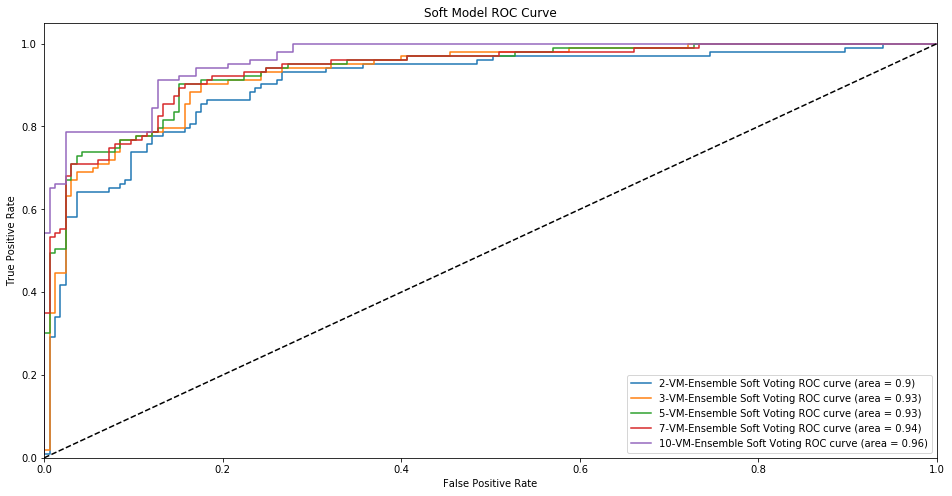

In [53]:
# Play with Weights
plt.figure()
voters = {}
for x in [2,3,5,7,10]:
    ECH = EnsembleVoteClassifier([ensemble_models.get(key) for key in hard_models.Model[:x]], voting='hard')
    ECS = EnsembleVoteClassifier([ensemble_models.get(key) for key in prob_models.Model[:x]], voting='soft')
    print('\n{}-Voting Models: 5-fold cross validation:\n'.format(x))
    
    for clf, label in zip([ECS, ECH], 
                          ['{}-VM-Ensemble Soft Voting'.format(x),
                           '{}-VM-Ensemble Hard Voting'.format(x)]):
        scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
        print("Train CV Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
        md = clf.fit(X_train, y_train)    
        clfs.append(md)        
        
        Test_Score = metrics.accuracy_score(clf.predict(X_test), y_test)
        print("Test Accuracy: %0.2f " % Test_Score)
        
        CV_Score = scores.mean()
        STDev = scores.std()
        
        global results
        results = results.append({'Model': label,'Para': clf, 'CV Mean': CV_Score,
                'Test_Score':Test_Score,'CV STDEV': STDev}, ignore_index=True)
        voters[label] = clf
        
        # Model on Full Data
        md = clf.fit(X,y)
        submission = md.predict(test_df)
        df = pd.DataFrame({'PassengerId':test_df.index,'Survived':submission})
        if save == True:
            df.to_csv("{}.csv".format(label),header=True,index=False)
        
        if clf is ECH:
            # Hard Correlation
            train_hard_pred_matrix = pd.concat((train_hard_pred_matrix, pd.DataFrame({label: md.predict(X)})), axis=1)
            test_hard_pred_matrix = pd.concat((test_hard_pred_matrix, pd.DataFrame({label: submission})), axis=1)
        
        elif clf is ECS:
            # Add to Roc Curve
            fpr, tpr, _ = roc_curve(y_test, md.predict_proba(X_test)[:,1])
            roc_auc = auc(fpr, tpr)
            print('ROC AUC: %0.2f' % roc_auc)
            plt.plot(fpr, tpr, label='{} ROC curve (area = {:.2})'.format(label, roc_auc))
            # Soft Correlation
            train_soft_pred_matrix = pd.concat((train_soft_pred_matrix, pd.DataFrame({label: md.predict(X)})), axis=1)
            test_soft_pred_matrix = pd.concat((test_soft_pred_matrix, pd.DataFrame({label: md.predict_proba(test_df)[:,1]})), axis=1)
        
        
# Plot
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Soft Model ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Sklearn Voter Pipeline

Talking about pipelines, Sklearn's ensemble voting is structured as one!

In [54]:
voters.get('10-VM-Ensemble Hard Voting')

EnsembleVoteClassifier(clfs=[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features=0.55000000000000004,
            max_leaf_nodes=9, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_f...wski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='distance')],
            refit=True, verbose=0, voting='hard', weights=None)

## Stacking Models
<a id="Stack"></a>
“Stacking is a way of combining multiple models, that introduces the concept of a meta learner. It is less widely used than bagging and boosting. Unlike bagging and boosting, stacking may be (and normally is) used to combine models of different types.” - Anshul Joshi [1]

Big shoutout to Manohar Swamynathan, author of Mastering Machine Learning with Python in Six Steps, who eloquently explains and took me step by step through stacks in Python. [2]

Next:
Could target high false negative through stacking methods, since it builds models off model weakness.

Read more here:

[1] https://www.quora.com/What-is-stacking-in-machine-learning 

[2] https://github.com/Apress/mastering-ml-w-python-in-six-steps/blob/master/Chapter_4_Code/Code/Stacking.ipynb

In [55]:
Xstack = X.copy()
ystack = y.copy()
X_trainstack = X_train.copy()
X_teststack = X_test.copy()
y_trainstack = y_train.copy()
y_teststack = y_test.copy()

In [56]:
from sklearn import cross_validation
kfold = cross_validation.StratifiedKFold(y=y_trainstack, n_folds=5, random_state=rstate)
num_trees = 10
verbose = True # to print the progress

clfs = [ensemble_models.get('KNN'),
        ensemble_models.get('XGBstandard')]

# Creating train and test sets for blending
dataset_blend_train = np.zeros((X_trainstack.shape[0], len(clfs)))
dataset_blend_test = np.zeros((X_teststack.shape[0], len(clfs)))
dataset_blend_test_df = np.zeros((test_df.shape[0], len(clfs)))

print('5-fold cross validation:')
for i, clf in enumerate(clfs):   
    scores = cross_validation.cross_val_score(clf, X_trainstack, y_trainstack, cv=kfold, scoring='accuracy')
    print("##### Base Model %0.0f #####" % i)
    print("Train CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
    clf.fit(X_trainstack, y_trainstack)   
    print("Train Accuracy: %0.2f " % (metrics.accuracy_score(clf.predict(X_trainstack), y_trainstack)))
    dataset_blend_train[:,i] = clf.predict_proba(X_trainstack)[:, 1]
    dataset_blend_test[:,i] = clf.predict_proba(X_teststack)[:, 1]
    dataset_blend_test_df[:,i] = clf.predict_proba(test_df)[:, 1]
    print("Test Accuracy: %0.2f \n" % (metrics.accuracy_score(clf.predict(X_teststack), y_teststack)))    

print("##### Meta Model #####")
clf = LogisticRegression()
scores = cross_validation.cross_val_score(clf, dataset_blend_train, y_trainstack, cv=kfold, scoring=scoring)
clf.fit(dataset_blend_train, y_trainstack)
print("Train CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
print("Train Accuracy: %0.2f " % (metrics.accuracy_score(clf.predict(dataset_blend_train), y_trainstack)))
print("Test Accuracy: %0.2f " % (metrics.accuracy_score(clf.predict(dataset_blend_test), y_teststack)))

# Correlate Results
#test_hard_pred_matrix = pd.concat((test_hard_pred_matrix, pd.DataFrame({label: clf.predict(dataset_blend_test_df)})), axis=1)
#train_hard_pred_matrix = pd.concat((train_hard_pred_matrix, pd.DataFrame({label: model.predict(dataset_blend_train)})), axis=1)

# Save
if save = True:
    pd.DataFrame({'PassengerId':test_df.index, 
        'Survived':clf.predict(dataset_blend_test_df)}).to_csv(
        "{}.csv".format("Stacked"),header=True,index=False)

5-fold cross validation:
##### Base Model 0 #####
Train CV Accuracy: 0.80 (+/- 0.03)
Train Accuracy: 1.00 
Test Accuracy: 0.79 

##### Base Model 1 #####
Train CV Accuracy: 0.81 (+/- 0.04)
Train Accuracy: 0.89 
Test Accuracy: 0.81 

##### Meta Model #####
Train CV Accuracy: 1.00 (+/- 0.00)
Train Accuracy: 1.00 
Test Accuracy: 0.78 



Evaluation Method: accuracy
Train CV Accuracy: 0.82 (+/- 0.03) [stacked]
Test_Score: 0.80223880597


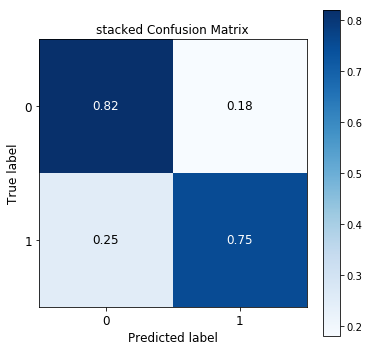

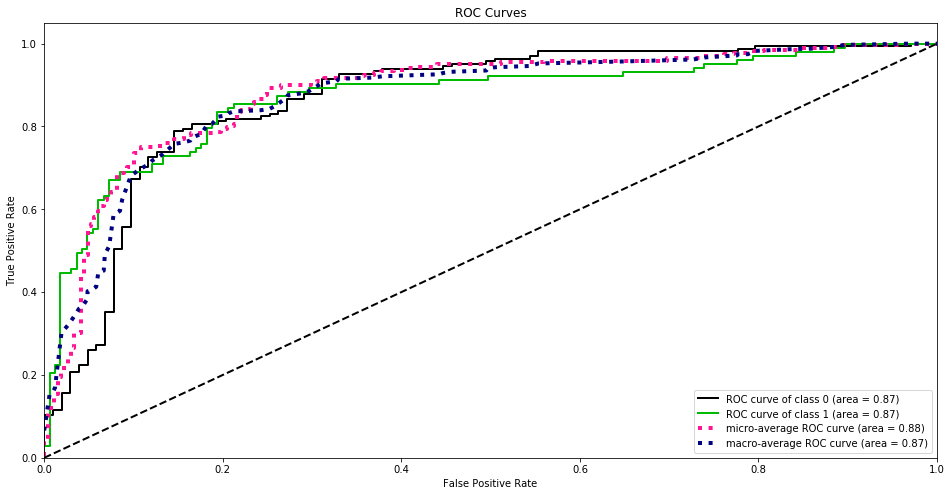

In [57]:
score = cross_val_score(clf, X, y, cv=cv, scoring=scoring)
norm_save(clf, score, "stacked")
eval_plot(clf)

### Output Submission Matrix for Experimental Stacking

Add Link

In [58]:
# Add Validation Set
# Train Prep
train_hard_pred_matrix = train_hard_pred_matrix.set_index([traindex])
train_hard_pred_matrix = pd.concat([train_hard_pred_matrix, Survived], axis=1)
# Soft
train_soft_pred_matrix = train_soft_pred_matrix.set_index([traindex])
train_soft_pred_matrix = pd.concat([train_soft_pred_matrix, Survived], axis=1)

# Test Prep
test_hard_pred_matrix = test_hard_pred_matrix.set_index([testdex])
# Soft
test_soft_pred_matrix = test_soft_pred_matrix.set_index([testdex])

# OUTPUT SUBMISSION RESULTS
# Test
test_hard_pred_matrix.to_csv("Titanic Support/Submission Matrix/test_hard_pred_matrix.csv")
test_soft_pred_matrix.to_csv("Titanic Support/Submission Matrix/test_soft_pred_matrix.csv")
# Train
train_hard_pred_matrix.to_csv("Titanic Support/Submission Matrix/train_hard_pred_matrix.csv")
train_soft_pred_matrix.to_csv("Titanic Support/Submission Matrix/train_soft_pred_matrix.csv")

## Table of Results
<a id="TOR"></a>

**Sorted by Cross Validated Mean Score**

In [59]:
results.sort_values(by=["CV Mean"], ascending=False, inplace=True)
results.to_csv("titanic_clf_results.csv", index=False)
results

,Model,Para,Test_Score,CV Mean,CV STDEV
19,5-VM-Ensemble Soft Voting,EnsembleVoteClassifier(clfs=[RandomForestClass...,0.832090,0.837724,0.030745
21,7-VM-Ensemble Soft Voting,EnsembleVoteClassifier(clfs=[RandomForestClass...,0.824627,0.834524,0.029914
23,10-VM-Ensemble Soft Voting,EnsembleVoteClassifier(clfs=[RandomForestClass...,0.835821,0.832924,0.027560
17,3-VM-Ensemble Soft Voting,EnsembleVoteClassifier(clfs=[RandomForestClass...,0.835821,0.831298,0.029377
20,5-VM-Ensemble Hard Voting,EnsembleVoteClassifier(clfs=[RandomForestClass...,0.828358,0.829724,0.024528
0,Random_Forest,"{'max_depth': 9, 'max_leaf_nodes': 9, 'n_estim...",0.839552,0.829698,0.032009
18,3-VM-Ensemble Hard Voting,EnsembleVoteClassifier(clfs=[RandomForestClass...,0.839552,0.829698,0.032009
24,10-VM-Ensemble Hard Voting,EnsembleVoteClassifier(clfs=[RandomForestClass...,0.832090,0.828124,0.024588
15,2-VM-Ensemble Soft Voting,EnsembleVoteClassifier(clfs=[RandomForestClass...,0.835821,0.828098,0.029991
22,7-VM-Ensemble Hard Voting,EnsembleVoteClassifier(clfs=[RandomForestClass...,0.824627,0.826524,0.026548


## Classification Evaluation
[Scikit-Plot Documentation](http://scikit-plot.readthedocs.io/en/stable/Quickstart.html)


 Report:
             precision    recall  f1-score   support

          0       0.86      0.87      0.86       110
          1       0.79      0.77      0.78        69

avg / total       0.83      0.83      0.83       179


 Matrix:


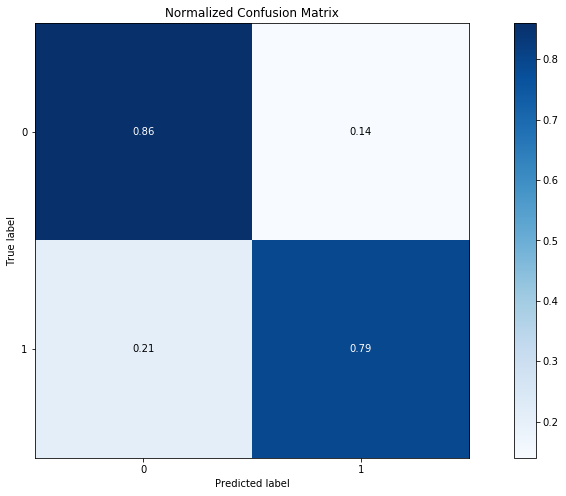

In [60]:
# Reinstate Data, since it was meddled with during Stacked Models
X = train_df.drop(["Survived"] , axis=1)
y = train_df["Survived"]

# Stratified Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

evalmodel = EnsembleVoteClassifier([ensemble_models.get(key) for key in prob_models.Model[:7]], voting='soft')
evalmodel.fit(X_train, y_train)
y_pred = evalmodel.predict(X_test)
# Report
print("\n Report:")
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)
# Matrix
print("\n Matrix:")
skplt.metrics.plot_confusion_matrix(y_pred, y_test, normalize=True)
plt.show()

In [61]:
# # Predict Submission Set and Output to CSV
# clf = EnsembleVoteClassifier([ensemble_models.get(key) for key in prob_models.Model[:7]], voting='soft')
# md = clf.fit(X, y)
# df = pd.DataFrame({'PassengerId':test_df.index, 'Survived':md.predict(test_df)})
# df.to_csv("Soft_Voting_7_TopModel", index=False)

In [62]:
import time
end = time.time()
print("Notebook took %0.2f minutes to Run"%((end - start)/60))

Notebook took 23.75 minutes to Run


### **Reflection**
<a id="REFL"></a>
A recurrent theme that I have observed is that the accuracy on the testing set is always higher than that of the submission set. This suggests that there is a disconnected representation of the underlying data distributions. A likely contributor to this problem is the quality of pre-processing, whose features appeared to have redundant effects, such as Title and Sex. A quick fix could be dimensionality reduction, but ultimately if proper exploration of features is conducted, then the “garbage in” problem can be minimized.

I think for this type of problem, elaborating on the stacked methodology might be key.

**On Confusion Matrix** <br>
Accross the board, most errors are false negatives. The model expected many of the deceased to have survived. This is perhaps why the ensembling only provided minor improvements, since it combined models with the same underlying prediction problem. 


**Possible Improvements** <br>
- To counter high false negatives, perhaps target *Specificity* (True Negative Rate) with certain models, and ensemble? Wonder what the tradeoff is. Could also experiment with the missclassification by ID (Observation). I tried stacking to get around this problem, but it still persists.
- I also want to put more work and research into stacking, since I am (still) utilizing it sub-optimally. 
- Add shrinkage methods, or dimensionality reduction to reduce redundancy. Since the data is sparse, L1 regularization is better.
- Add correlation matrix for the submissions.
- Try the Box Cox transformation for continuous variables, instead of sklearn's standard scaler.